https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

In [37]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1, l2

print(tf.__version__)

2.2.0


In [2]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 1193s 0us/step


In [6]:
FEATURES = 28

In [7]:
ds = tf.data.experimental.CsvDataset( gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [8]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [9]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


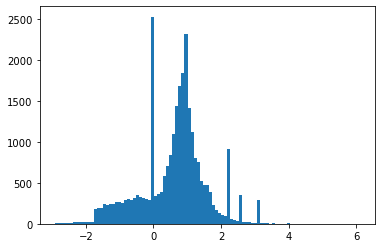

In [10]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [11]:
print(list(ds.take(2).as_numpy_iterator())[0])
print(list(ds.take(2).as_numpy_iterator())[1])

(1.0, 0.8692932, -0.6350818, 0.22569026, 0.32747006, -0.6899932, 0.75420225, -0.24857314, -1.0920639, 0.0, 1.3749921, -0.6536742, 0.9303491, 1.1074361, 1.1389043, -1.5781983, -1.0469854, 0.0, 0.65792954, -0.01045457, -0.04576717, 3.1019614, 1.35376, 0.9795631, 0.97807616, 0.92000484, 0.72165745, 0.98875093, 0.87667835)
(1.0, 0.9075421, 0.32914728, 0.35941187, 1.4979699, -0.31300953, 1.0955306, -0.5575249, -1.5882298, 2.1730762, 0.8125812, -0.21364193, 1.2710146, 2.2148721, 0.49999395, -1.2614318, 0.73215616, 0.0, 0.3987009, -1.1389301, -0.0008191102, 0.0, 0.3022199, 0.83304816, 0.98569965, 0.9780984, 0.77973217, 0.99235576, 0.7983426)


In [12]:
featVals=[features.numpy()[0] for features,label in packed_ds.take(1000)]

t=packed_ds.take(20000)

In [13]:
t = [label.numpy() for features,label in packed_ds.take(20000)]
print("Values 1:",sum(t))
print("Values 0:",sum(np.equal(t,0)))

Values 1: 10457.0
Values 0: 9543


In [14]:
t = np.array([features.numpy() for features,label in packed_ds.take(20000)])
print("Min Value:",min(t.flatten()))
print("Max Value:",max(t.flatten()))

Min Value: -2.960813
Max Value: 16.131908


In [17]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500  # TODO: Note that the paper used 100, we can increase this to reduce training time.
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [18]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [19]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [20]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [21]:
# https://www.tensorflow.org/tutorials/text/transformer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self):
    super(CustomSchedule, self).__init__()
    
  def __call__(self, step):
    lr = tf.clip_by_value(0.05 / 1.0000002**step, clip_value_min=0.000001, clip_value_max=0.05)
    return lr

In [22]:
tf.range(25, dtype=tf.float32)

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.],
      dtype=float32)>

Text(0.5, 0, 'Train Step')

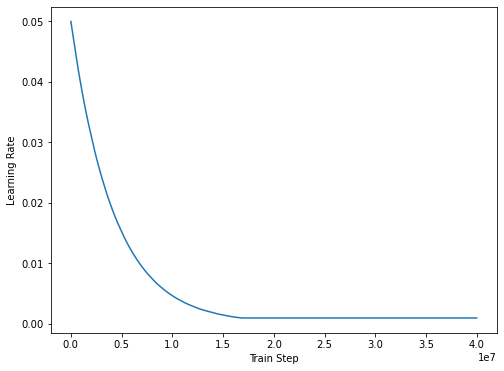

In [23]:
temp_lr_schedule = CustomSchedule()
plt.figure(figsize = (8,6))
lrs = temp_lr_schedule(tf.range(40000000, dtype=tf.float32))
plt.plot(lrs)
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [24]:
lrs

<tf.Tensor: shape=(40000000,), dtype=float32, numpy=
array([0.05      , 0.04999999, 0.04999998, ..., 0.00091578, 0.00091578,
       0.00091578], dtype=float32)>

In [25]:
def get_optimizer():
  lr_schedule = CustomSchedule()
  return tf.keras.optimizers.SGD(lr_schedule, momentum=0.9)

In [26]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', min_delta=0.00001, patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [27]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.AUC(name='AUC'),
                  tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=2)
  return history

In [28]:
size_histories = {}

##  https://archive.ics.uci.edu/ml/datasets/HIGGS

In [29]:
# https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomNormal
first_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=42)
outer_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.001, seed=42)
other_initializers = tf.keras.initializers.RandomNormal(mean=0., stddev=0.05, seed=42)


weight_decay=0.00001
paper_model = tf.keras.Sequential([
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,), kernel_initializer=first_initializer, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dropout(0.5), # Top Hidden Layer
    layers.Dense(1, activation='sigmoid', kernel_initializer=outer_initializer, kernel_regularizer=l2(weight_decay))
    
])

## Paper Model Architecture 

In [30]:
size_histories['paper'] = compile_and_fit(paper_model, 'sizes/paper')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 279,901
Trainable params: 279,901
Non-trainable params: 0
__________________________________________________

Epoch 36/10000
.20/20 - 0s - loss: 0.6693 - AUC: 0.6700 - binary_crossentropy: 0.6617 - accuracy: 0.6003 - val_loss: 0.6711 - val_AUC: 0.6623 - val_binary_crossentropy: 0.6635 - val_accuracy: 0.5640
Epoch 37/10000
.20/20 - 0s - loss: 0.6690 - AUC: 0.6692 - binary_crossentropy: 0.6614 - accuracy: 0.5991 - val_loss: 0.6701 - val_AUC: 0.6636 - val_binary_crossentropy: 0.6626 - val_accuracy: 0.5970
Epoch 38/10000
.20/20 - 0s - loss: 0.6666 - AUC: 0.6762 - binary_crossentropy: 0.6590 - accuracy: 0.6074 - val_loss: 0.6687 - val_AUC: 0.6653 - val_binary_crossentropy: 0.6611 - val_accuracy: 0.5930
Epoch 39/10000
.20/20 - 0s - loss: 0.6675 - AUC: 0.6750 - binary_crossentropy: 0.6600 - accuracy: 0.6092 - val_loss: 0.6703 - val_AUC: 0.6643 - val_binary_crossentropy: 0.6627 - val_accuracy: 0.5700
Epoch 40/10000
.20/20 - 0s - loss: 0.6675 - AUC: 0.6762 - binary_crossentropy: 0.6599 - accuracy: 0.6048 - val_loss: 0.6696 - val_AUC: 0.6690 - val_binary_crossentropy: 0.6620 - val_accuracy: 0.6030
Epoch

Epoch 78/10000
.20/20 - 0s - loss: 0.6531 - AUC: 0.7100 - binary_crossentropy: 0.6455 - accuracy: 0.6538 - val_loss: 0.6584 - val_AUC: 0.6927 - val_binary_crossentropy: 0.6507 - val_accuracy: 0.6370
Epoch 79/10000
.20/20 - 0s - loss: 0.6516 - AUC: 0.7131 - binary_crossentropy: 0.6439 - accuracy: 0.6550 - val_loss: 0.6570 - val_AUC: 0.7017 - val_binary_crossentropy: 0.6493 - val_accuracy: 0.6430
Epoch 80/10000
.20/20 - 0s - loss: 0.6560 - AUC: 0.7032 - binary_crossentropy: 0.6483 - accuracy: 0.6448 - val_loss: 0.6586 - val_AUC: 0.6903 - val_binary_crossentropy: 0.6509 - val_accuracy: 0.6130
Epoch 81/10000
.20/20 - 0s - loss: 0.6550 - AUC: 0.6999 - binary_crossentropy: 0.6474 - accuracy: 0.6372 - val_loss: 0.6693 - val_AUC: 0.6665 - val_binary_crossentropy: 0.6617 - val_accuracy: 0.5610
Epoch 82/10000
.20/20 - 0s - loss: 0.6620 - AUC: 0.6857 - binary_crossentropy: 0.6543 - accuracy: 0.6230 - val_loss: 0.6600 - val_AUC: 0.6904 - val_binary_crossentropy: 0.6523 - val_accuracy: 0.6310
Epoch

Epoch 119/10000
.20/20 - 0s - loss: 0.6358 - AUC: 0.7384 - binary_crossentropy: 0.6280 - accuracy: 0.6959 - val_loss: 0.6575 - val_AUC: 0.6924 - val_binary_crossentropy: 0.6496 - val_accuracy: 0.6160
Epoch 120/10000
.20/20 - 0s - loss: 0.6388 - AUC: 0.7347 - binary_crossentropy: 0.6310 - accuracy: 0.6859 - val_loss: 0.6525 - val_AUC: 0.7162 - val_binary_crossentropy: 0.6446 - val_accuracy: 0.6700
Epoch 121/10000
.20/20 - 0s - loss: 0.6373 - AUC: 0.7339 - binary_crossentropy: 0.6294 - accuracy: 0.6889 - val_loss: 0.6563 - val_AUC: 0.6984 - val_binary_crossentropy: 0.6484 - val_accuracy: 0.6490
Epoch 122/10000
.20/20 - 0s - loss: 0.6406 - AUC: 0.7284 - binary_crossentropy: 0.6327 - accuracy: 0.6803 - val_loss: 0.6621 - val_AUC: 0.6750 - val_binary_crossentropy: 0.6542 - val_accuracy: 0.5880
Epoch 123/10000
.20/20 - 0s - loss: 0.6418 - AUC: 0.7261 - binary_crossentropy: 0.6339 - accuracy: 0.6800 - val_loss: 0.6656 - val_AUC: 0.6633 - val_binary_crossentropy: 0.6577 - val_accuracy: 0.5830


Epoch 160/10000
.20/20 - 0s - loss: 0.6231 - AUC: 0.7600 - binary_crossentropy: 0.6149 - accuracy: 0.7262 - val_loss: 0.6585 - val_AUC: 0.6882 - val_binary_crossentropy: 0.6504 - val_accuracy: 0.6380
Epoch 161/10000
.20/20 - 0s - loss: 0.6245 - AUC: 0.7556 - binary_crossentropy: 0.6164 - accuracy: 0.7192 - val_loss: 0.6574 - val_AUC: 0.6835 - val_binary_crossentropy: 0.6493 - val_accuracy: 0.6360
Epoch 162/10000
.20/20 - 0s - loss: 0.6224 - AUC: 0.7583 - binary_crossentropy: 0.6142 - accuracy: 0.7241 - val_loss: 0.6576 - val_AUC: 0.6938 - val_binary_crossentropy: 0.6495 - val_accuracy: 0.6490
Epoch 163/10000
.20/20 - 0s - loss: 0.6339 - AUC: 0.7348 - binary_crossentropy: 0.6258 - accuracy: 0.6942 - val_loss: 0.6630 - val_AUC: 0.6851 - val_binary_crossentropy: 0.6548 - val_accuracy: 0.6490
Epoch 164/10000
.20/20 - 0s - loss: 0.6276 - AUC: 0.7518 - binary_crossentropy: 0.6194 - accuracy: 0.7156 - val_loss: 0.6577 - val_AUC: 0.6889 - val_binary_crossentropy: 0.6496 - val_accuracy: 0.6430


Epoch 201/10000

Epoch: 200, AUC:0.7816,  accuracy:0.7548,  binary_crossentropy:0.6014,  loss:0.6098,  val_AUC:0.6670,  val_accuracy:0.6170,  val_binary_crossentropy:0.6548,  val_loss:0.6632,  
.20/20 - 0s - loss: 0.6098 - AUC: 0.7816 - binary_crossentropy: 0.6014 - accuracy: 0.7548 - val_loss: 0.6632 - val_AUC: 0.6670 - val_binary_crossentropy: 0.6548 - val_accuracy: 0.6170
Epoch 202/10000
.20/20 - 0s - loss: 0.6092 - AUC: 0.7806 - binary_crossentropy: 0.6008 - accuracy: 0.7578 - val_loss: 0.6620 - val_AUC: 0.6779 - val_binary_crossentropy: 0.6535 - val_accuracy: 0.6370
Epoch 203/10000
.20/20 - 0s - loss: 0.6074 - AUC: 0.7853 - binary_crossentropy: 0.5989 - accuracy: 0.7620 - val_loss: 0.6623 - val_AUC: 0.6568 - val_binary_crossentropy: 0.6539 - val_accuracy: 0.6180
Epoch 204/10000
.20/20 - 0s - loss: 0.6052 - AUC: 0.7863 - binary_crossentropy: 0.5967 - accuracy: 0.7670 - val_loss: 0.6625 - val_AUC: 0.6674 - val_binary_crossentropy: 0.6540 - val_accuracy: 0.6290
Epoch 205/10000
.20/20

.20/20 - 0s - loss: 0.5975 - AUC: 0.8040 - binary_crossentropy: 0.5887 - accuracy: 0.7831 - val_loss: 0.6608 - val_AUC: 0.6689 - val_binary_crossentropy: 0.6521 - val_accuracy: 0.6360
Epoch 242/10000
.20/20 - 0s - loss: 0.5952 - AUC: 0.8052 - binary_crossentropy: 0.5865 - accuracy: 0.7890 - val_loss: 0.6632 - val_AUC: 0.6637 - val_binary_crossentropy: 0.6545 - val_accuracy: 0.6250
Epoch 243/10000
.20/20 - 0s - loss: 0.5943 - AUC: 0.8058 - binary_crossentropy: 0.5855 - accuracy: 0.7911 - val_loss: 0.6648 - val_AUC: 0.6590 - val_binary_crossentropy: 0.6560 - val_accuracy: 0.6160
Epoch 244/10000
.20/20 - 0s - loss: 0.5928 - AUC: 0.8091 - binary_crossentropy: 0.5841 - accuracy: 0.7959 - val_loss: 0.6661 - val_AUC: 0.6594 - val_binary_crossentropy: 0.6573 - val_accuracy: 0.6210
Epoch 245/10000
.20/20 - 0s - loss: 0.5910 - AUC: 0.8099 - binary_crossentropy: 0.5822 - accuracy: 0.8000 - val_loss: 0.6641 - val_AUC: 0.6641 - val_binary_crossentropy: 0.6554 - val_accuracy: 0.6310
Epoch 246/10000


.20/20 - 0s - loss: 0.5882 - AUC: 0.8204 - binary_crossentropy: 0.5792 - accuracy: 0.8052 - val_loss: 0.6695 - val_AUC: 0.6499 - val_binary_crossentropy: 0.6605 - val_accuracy: 0.6190
Epoch 283/10000
.20/20 - 0s - loss: 0.5859 - AUC: 0.8218 - binary_crossentropy: 0.5769 - accuracy: 0.8106 - val_loss: 0.6650 - val_AUC: 0.6577 - val_binary_crossentropy: 0.6560 - val_accuracy: 0.6330
Epoch 284/10000
.20/20 - 0s - loss: 0.5835 - AUC: 0.8250 - binary_crossentropy: 0.5744 - accuracy: 0.8165 - val_loss: 0.6697 - val_AUC: 0.6426 - val_binary_crossentropy: 0.6607 - val_accuracy: 0.6090
Epoch 285/10000
.20/20 - 0s - loss: 0.5903 - AUC: 0.8180 - binary_crossentropy: 0.5812 - accuracy: 0.8004 - val_loss: 0.6657 - val_AUC: 0.6571 - val_binary_crossentropy: 0.6566 - val_accuracy: 0.6170
Epoch 286/10000
.20/20 - 0s - loss: 0.5950 - AUC: 0.8133 - binary_crossentropy: 0.5859 - accuracy: 0.7883 - val_loss: 0.6583 - val_AUC: 0.6700 - val_binary_crossentropy: 0.6492 - val_accuracy: 0.6480
Epoch 287/10000


In [31]:
size_histories['paper'].history['AUC'][0:10]

[0.5019132494926453,
 0.511874258518219,
 0.5480530261993408,
 0.5680968761444092,
 0.5784492492675781,
 0.5897914171218872,
 0.6031762957572937,
 0.6107280850410461,
 0.6245710253715515,
 0.6292386651039124]

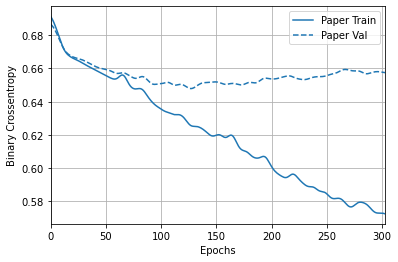

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)

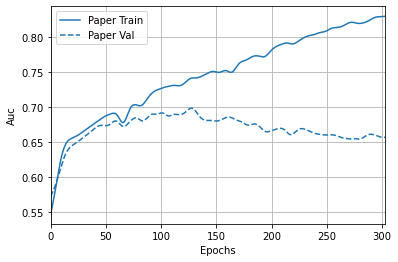

In [33]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'AUC', smoothing_std=10)
plotter.plot(size_histories)

Text(0.5, 0, 'Epochs [Log Scale]')

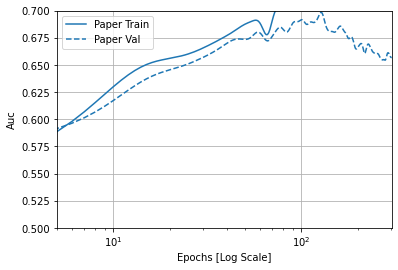

In [34]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [35]:
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


In [36]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")